# Federated kernel SVM classification

In the present notebook, the idea for a Federated non-linear support vector machine (SVM) classification is presented. 
The model is encapsulated in the Sherpa.ai Federated Learning Framework on for a synthetic database.
Moreover, differential privacy is applied and its impact on the global model is assessed. 

We start by creating a synthetic database: 

In [1]:
import shfl
from shfl.data_base.data_base import LabeledDatabase
from sklearn.datasets import make_classification
import numpy as np
from shfl.model.linear_classifier_model import LinearClassifierModel
import numpy as np
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import metrics

# Create database:
n_features = 2
n_classes = 3
data, labels = make_classification(
    n_samples=1000, n_features=n_features, n_informative=2, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, weights=None, flip_y=0.1, class_sep=0.5)
database = LabeledDatabase(data, labels)

train_data, train_labels, test_data, test_labels = database.load_data()

# Model params if using NuSVC:
#nu = 0.7 
#kwargs = {'nu':nu}
#model_use = NuSVC(**kwargs)

# if using SVC:
C = 1
kwargs = {'C':C}
model_use = SVC(**kwargs)

In [2]:
print("Shape of train and test data: " + str(train_data.shape) + str(test_data.shape))
print("Shape of train and test labels: " + str(train_labels.shape) + str(test_labels.shape))
print(train_data[0,:])

Shape of train and test data: (800, 2)(200, 2)
Shape of train and test labels: (800,)(200,)
[-0.78006141 -0.69072309]


Next, we define the new class for SVM using [`sklearn`'s Support Vector Machine classifiers](https://scikit-learn.org/stable/modules/svm.html).
By the implementation below, you can use either `SVC` or `NuSVC`:

In [3]:
class SVMClassifierModel(LinearClassifierModel):
    """
    This class offers support for scikit-learn SVM non-linear classification. It implements [TrainableModel](../Model/#trainablemodel-class)

    # Arguments:
        n_features: integer number of features (independent variables).
        classes: array of classes to predict. At least 2 classes must be provided.
        model: initialized model to employ. Options are [SVC (default)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 
        and [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html)
    """
    def __init__(self, n_features, classes, model=None):
        if model is None:
            model = SVC()
        self._check_initialization(n_features, classes)
        self._model = model
        self._n_features = n_features
        classes = np.sort(np.asarray(classes))
        self._model.classes_ = classes
        params = np.array([], dtype=np.int64).reshape(0, (n_features + 1))
        self.set_model_params(params)
        
    def train(self, data, labels):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)

        # Arguments
            data: Data, array-like of shape (n_samples, n_features)
            labels: Target classes, array-like of shape (n_samples,) 
        """
        
        data_array = np.row_stack((self.get_model_params(), 
                                   np.column_stack((data, labels)) ))
        data_array_unq, count = np.unique(data_array, axis=0, return_counts=True)
        data = data_array_unq[:, 0:-1]
        labels = data_array_unq[:, -1]
        
        self._check_data(data)
        self._check_labels_train(labels)
        self._model.fit(data, labels)

    def get_model_params(self):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)
        """
        classes_index = [np.full(i_nSV, i_class) for (i_class, i_nSV) in 
                  zip(range(len(self._model.classes_)), self._model.n_support_)]
        classes_index = np.hstack(classes_index)
        params = np.column_stack((self._model.support_vectors_, classes_index))
        params = params.astype(self._model.support_vectors_.dtype)
        
        return params

    def set_model_params(self, params):
        """
        Implementation of abstract method of class [TrainableModel](../Model/#trainablemodel-class)
        """
        self._model.support_vectors_ = np.ascontiguousarray(params[:, 0:-1], dtype=params.dtype)
        labels = params[:,-1]
        n_support = [np.sum(labels == i_class) for i_class in range(len(self._model.classes_))]
        self._model._n_support = np.asarray(n_support, dtype=np.int32)

In [4]:
import matplotlib.pyplot as plt


def plot_2D_decision_boundary(model, data, labels, title=None):
    # Step size of the mesh. Smaller it is, better the quality
    h = .02 
    # Color map
    cmap = plt.cm.Set1
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(9,6))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap,
               alpha=0.6,
               aspect='auto', origin='lower')
    # Plot data:
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap, s=40, marker='o')
    
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

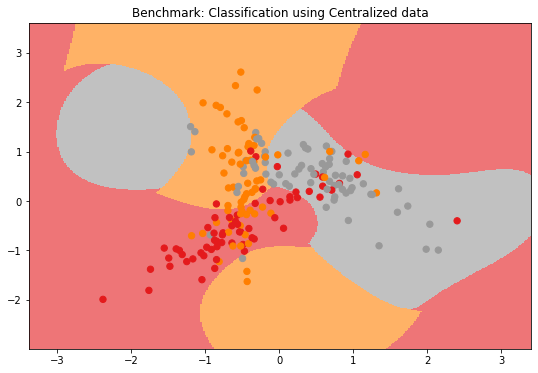

Test performance using centralized data: (0.6906950753478981, 0.5351975410450558)


In [5]:
# Train global model using framework's class: 
classes = [i for i in range(0,n_classes)] 
model_centralized = SVMClassifierModel(n_features=n_features, classes=classes, model=model_use)
model_centralized.train(data=train_data, labels=train_labels)
if n_features == 2:
    plot_2D_decision_boundary(model_centralized, test_data, labels=test_labels, title = "Benchmark: Classification using Centralized data")
print("Test performance using centralized data: " + str(model_centralized.evaluate(test_data, test_labels)))

## Aggregation problem
`sklearn` provides three options for classification: `LinearSVC`, `SVC` and `NuSVC`. 
The linear version `LinearSVC` is easily incorporated in the platform, since the aggregation of the model is straightforward. 
Instead, for `SVC` and `NuSVC`, the output model's parameters are more complex, since they depend on the number of support vectors for each class. 
Thus, in principle, each client would deliver parameters with different dimensions, which are not straightforward to aggregate. 

Here, we use the clients' support vectors to *train a global model directly on the server*, obtaining the aggregated model: 

In [6]:
import numpy as np
import inspect
from shfl.federated_aggregator.federated_aggregator import FederatedAggregator

class GlobalModelAggregator(FederatedAggregator):
    """
    Trains the global model over the local parameters to aggregate them.

    It implements [Federated Aggregator](../federated_aggregator/#federatedaggregator-class)
    """

    def aggregate_weights(self, clients_params):
        """
        Implementation of abstract method of class [AggregateWeightsFunction](../federated_aggregator/#federatedaggregator-class)
        # Arguments:
            clients_params: list of multi-dimensional (numeric) arrays. Each entry in the list contains the model's parameters of one client.

        # Returns
            aggregated_weights: aggregator weights representing the global learning model

        # References
            [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/abs/1602.05629)
        """
        caller_object = inspect.currentframe().f_back.f_locals['self']
        clients_params_array = np.vstack(clients_params)
        caller_object.global_model.train(clients_params_array[:, 0:-1], clients_params_array[:, -1].astype(int))

        return caller_object.global_model.get_model_params()

Once defined the aggregator, we can run the federated model as usual.
Note that the decision boundary can vary even by running the training on the same data (this is due to the internal shuffle of the data of the SVM solver). 
Thus, in order to compare the centralized and the federated models, it is more relevant to compare the scores on the test data:

Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148779710>: (0.700212704592977, 0.5500224988750563)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1487f4450>: (0.6612769485903813, 0.4905222147299019)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1488788d0>: (0.6511824933304492, 0.47569470451651563)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148878710>: (0.6716384112048454, 0.5057105410971728)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1488787d0>: (0.63313752794001, 0.45678826059074273)
Global model test performance : (0.7053320354748, 0.5576879826073918)



Accuracy round 1
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148779710>: (0.7003569110966904, 0.5502417450620292)
Test performance client <shfl.private.federated_

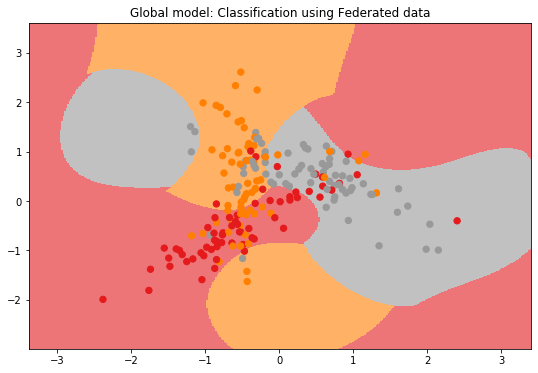

Model used: SVC


In [7]:
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_labels = iid_distribution.get_federated_data(num_nodes=5, percent=100)

classes = [i for i in range(0,n_classes)] 
def model_builder():
    model = SVMClassifierModel(n_features=n_features, classes=classes, model=model_use)
    return model

aggregator = GlobalModelAggregator()

federated_government = shfl.federated_government.FederatedGovernment(model_builder, federated_data, aggregator)
federated_government.run_rounds(n=3, test_data=test_data, test_label=test_labels)

if n_features == 2:
    plot_2D_decision_boundary(federated_government.global_model, test_data, test_labels, title = "Global model: Classification using Federated data")

print("Model used: " + type(federated_government.global_model._model).__name__)

## Adding Differential Privacy

In instance-based machine learning methods such as SVM or KNN, part of the data (or the entire data, in the worst case) constitute the resulting model. 
These methods are thus particularly exposed to reconstruction attacks (e.g. see [Yang et al. 2019](https://www.morganclaypool.com/doi/pdf/10.2200/S00960ED2V01Y201910AIM043)). 
In order to protect private information, we can apply Differential Privacy on the resulting model output from the clients and observe its influence on the federated global model. 

### Sensitivity by sampling:
We first estimate model's sensitivity by sampling.
Recall that the matrices of support vectors are the actual models' parameters, and that they can have differing number of rows.
We then need to define a distance between such matrices: we can choose the max of the Euclidean distance of their rows (see [matrix distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html)). 
The Gaussian mechanism is employed.

Note that the `sk-learn` SVM solver is *non-deterministic*. In fact, due to the internal data shuffle, the SVM solver may deliver slightly different support vectors when training on the same set. Moreover, even when setting the random seed (see [`random_state` input parameter](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), and simply switching one row in the training dataset, may result in slightly different output. 
As a matter of fact, in the sensitivity sampling, we consider databases that differ at most in one entry, or contain exactly the same data, yet some of the support vectors turn out to be different.
This said, the sensitivity sampling procedure for this case is expected to deliver results with high variance.

The resulting sensitivity is particularly high, and the application of DP dramatically deteriorates the performance of the global model:

In [8]:
from shfl.differential_privacy import SensitivitySampler
from shfl.differential_privacy import L1SensitivityNorm
from shfl.differential_privacy import SensitivityNorm
from scipy.spatial import distance_matrix
 
class UniformDistribution(shfl.differential_privacy.ProbabilityDistribution):
    """
    Implement Uniform sampling over the data
    """
    def __init__(self, sample_data):
        self._sample_data = sample_data

    def sample(self, sample_size):
        row_indices = np.random.choice(a=self._sample_data.shape[0], size=sample_size, replace=False)
        
        return self._sample_data[row_indices, :]
    
    
class SVMClassifierSample(SVMClassifierModel):
    
    def get(self, data_array):
        data = data_array[:, 0:-1]
        labels = data_array[:, -1].astype(int)
        params = np.array([], dtype=np.int64).reshape(0, (self._n_features + 1))
        self.set_model_params(params)
        train_model = self.train(data, labels)
        model_params = self.get_model_params()
        model_params = model_params[:,0:-1] # Exclude the classes indices
        
        return model_params.copy()


class MatrixSetXoRNorm(SensitivityNorm):
    """
    Distance matrix using only rows not in common.
    """
    def compute(self, x_1, x_2):
        nrows, ncols = x_1.shape
        dtype = {'names':['f{}'.format(i) for i in range(ncols)],
                   'formats':ncols * [x_1.dtype]}
        x = np.setxor1d(x_1.view(dtype), x_2.view(dtype))
        x = x.view(x_1.dtype).reshape(-1, ncols)
        if x.shape[0] is not 0:
            x = distance_matrix(x,x)
            x = x.max()
        else:
            x = 0

        return x

In [9]:
# Create sampling database:
n_instances = 400
sampling_data, sampling_labels = make_classification(
    n_samples=n_instances, n_features=n_features, n_informative=2, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, weights=None, flip_y=0.1, class_sep=0.1)  
sample_data = np.hstack((sampling_data, sampling_labels.reshape(-1,1)))

# Sampling sensitivity:
distribution = UniformDistribution(sample_data)
sampler = SensitivitySampler()

n_samples = 200 # must be <= n_instances
kwargs['random_state'] = 123
max_sensitivity, mean_sensitivity = sampler.sample_sensitivity(
    SVMClassifierSample(n_features=n_features, classes=classes, model=model_use), 
    MatrixSetXoRNorm(), distribution, n=n_samples, m=100)

print("Max sensitivity from sampling: " + str(max_sensitivity))
print("Mean sensitivity from sampling: " + str(mean_sensitivity))

Max sensitivity from sampling: 3.9733827472628978
Mean sensitivity from sampling: 0.5389563360086637


Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148779710>: (0.700212704592977, 0.5500224988750563)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1487f4450>: (0.6612769485903813, 0.4905222147299019)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1488788d0>: (0.6511824933304492, 0.47569470451651563)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148878710>: (0.6716384112048454, 0.5057105410971728)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1488787d0>: (0.63313752794001, 0.45678826059074273)
Global model test performance : (0.3333333333333333, 0.0)





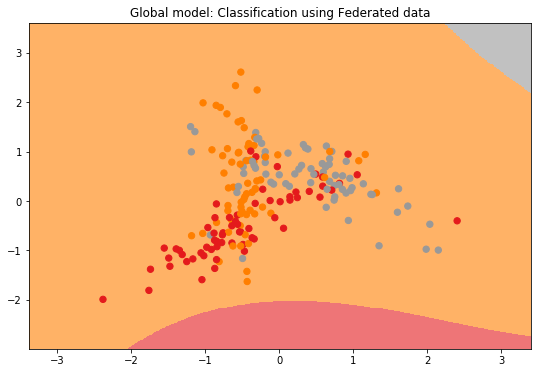

Model used: SVC


In [10]:
from shfl.differential_privacy import GaussianMechanism

sensitivity_array = np.full((n_features+1,), max_sensitivity)
sensitivity_array[-1] = 0  # We don't apply noise on the classes
params_access_definition = GaussianMechanism(sensitivity=sensitivity_array, epsilon_delta=(0.9, 0.9))
federated_governmentDP = shfl.federated_government.FederatedGovernment(
    model_builder, federated_data, aggregator, model_params_access=params_access_definition)

federated_governmentDP.run_rounds(n=1, test_data=test_data, test_label=test_labels)
if n_features == 2:
    plot_2D_decision_boundary(federated_governmentDP.global_model, test_data, test_labels, title = "Global model: Classification using Federated data")

print("Model used: " + type(federated_governmentDP.global_model._model).__name__)

### Sensitivity associated to the data: 
Since the SVM's parameters are constituted by the data itself, we might assume that the model's sensitivity is actually the sensitivity to apply on the data itself if one would try to access it (see [Laplace mechanism notebook](../differential_privacy/differential_privacy_laplace.ipynb)). 
We then take the component-wise variance of the data as the sensitivity. 
The resulting $\epsilon$-private global model's performance is then comparable to the non-private version:

Component-wise sensitivity: [0.41644615 0.43833613 0.        ]
Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148779710>: (0.700212704592977, 0.5500224988750563)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1487f4450>: (0.6612769485903813, 0.4905222147299019)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1488788d0>: (0.6511824933304492, 0.47569470451651563)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x148878710>: (0.6716384112048454, 0.5057105410971728)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1488787d0>: (0.63313752794001, 0.45678826059074273)
Global model test performance : (0.6657304510058403, 0.49778877145641265)





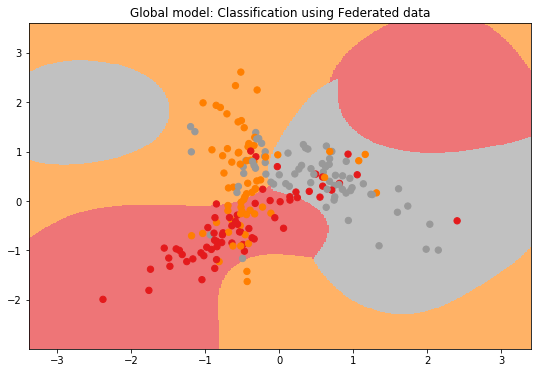

Model used: SVC


In [11]:
from shfl.differential_privacy import GaussianMechanism

sensitivity_array = np.var(sample_data, axis=0)
sensitivity_array[-1] = 0  # We don't apply noise on the classes
print("Component-wise sensitivity: " + str(sensitivity_array))

params_access_definition = GaussianMechanism(sensitivity=sensitivity_array, epsilon_delta=(0.9, 0.9))
federated_governmentDP = shfl.federated_government.FederatedGovernment(
    model_builder, federated_data, aggregator, model_params_access=params_access_definition)

federated_governmentDP.run_rounds(n=1, test_data=test_data, test_label=test_labels)
if n_features == 2:
    plot_2D_decision_boundary(federated_governmentDP.global_model, test_data, test_labels, title = "Global model: Classification using Federated data")

print("Model used: " + type(federated_governmentDP.global_model._model).__name__)

## Remarks

**Remark 1: Federated learning round.** In this approach, the model's parameters are the actual support vectors. Thus, at each learning round, the support vectors are sent by the clients to the central server, where an additional SVM is run to aggregate the global model. At that stage, the (global) support vectors are sent back to the clients and are used *together* with clients' data to train the local model. However, the global support vectors are not considered as local data, and thus are not stored as client's data on the node.   <br>
**Remark 2: Application of DP.** The model's sensitivity is highly responsive on the training data, and the resulting model's performance can be easily degenerated by application of DP. Sensitivity is computed both by sampling and data variance, and the former yields lower sensitivity. 
Nevertheless, neither of the two approaches fit in the definition of sensitivity based on either L1 and L2 norms, and a more general notion of distance should be introduced for a formal guarantee of DP (see [3.3 in Dwork et al. 2016](https://link.springer.com/chapter/10.1007/11681878_14)). <br>
**Remark 3: Reduction of training data.** Since the SVM is particularly sensitive to duplicates in the training data, these are removed when fitting the model. However, when applying DP, there aren't essentially any identical instances and more sophisticated reduction techniques for training data should be used (e.g. a clustering technique as in [Yu et al. 2003](http://hanj.cs.illinois.edu/pdf/kdd03_scalesvm.pdf)) since otherwise the set of training vectors would *keep growing* at each federated round and introducing excessive noise in the model. When DP is applied as in this approach, it is thus advisable to run only a few federated rounds. <br>
**Remark 4: Tuning for soft margin and kernel parameters.** In the presented case default values are used, however a tuning is in general needed for SVM models. Moreover,  